In [1]:
import os
from ordereddict import OrderedDict
os.environ['THEANO_FLAGS']="device=cpu"

from utils import tile_raster_images
from pylearn2.utils import serial
import theano
import theano.tensor as T

try:
    import PIL.Image as Image
except ImportError:
    import Image
import IPython.display as I

In [2]:
DIR_DATA = '/Users/vmisra/data/AE_experiments'
dir_model = os.path.join(DIR_DATA,'models')
dir_fuel = os.path.join(DIR_DATA,'fuel')

#Load models and data

In [9]:
model_folders = [model_folder \
               for model_folder in os.listdir(dir_model) \
               if os.path.isdir(os.path.join(dir_model,model_folder))]
model_folders = ['Z1e','Z1c_90','Z1b']
submodels = ['0.pkl','1.pkl','2.pkl','3.pkl']
final_model='finetune.pkl'

In [10]:
models = OrderedDict()
for model_folder in model_folders:
    models[model_folder] = OrderedDict()
    for submodel in submodels+[final_model]:
        path = os.path.join(dir_model,model_folder,submodel)
        if os.path.exists(path):
            models[model_folder][submodel] = serial.load(path)

In [11]:
test_data = serial.load(os.path.join(dir_fuel,'mnist_test_X.pkl'))

#Define graph

In [20]:
Xs = OrderedDict()
Ys = OrderedDict()
for model_folder in models:
    Xs[model_folder]=OrderedDict()
    Ys[model_folder]=OrderedDict()
    for (idx,submodel) in enumerate(models[model_folder].keys()[:-1]):
        Xs[model_folder][submodel] = models[model_folder][submodel].get_input_space().make_theano_batch()
        Y=Xs[model_folder][submodel]
        for jdx in range(idx+1):
            Y = models[model_folder][submodels[jdx]].encode(Y)
        for jdx in range(idx+1)[::-1]:
            Y = models[model_folder][submodels[jdx]].decode(Y)
        Ys[model_folder][submodel] = Y
    Xs[model_folder][final_model] = models[model_folder][final_model].get_input_space().make_theano_batch()
    Ys[model_folder][final_model] = models[model_folder][final_model].reconstruct(Xs[model_folder][final_model])

#Compute output

In [21]:
xhat = OrderedDict()
for model_folder in Ys:
    xhat[model_folder] = OrderedDict()
    for submodel in Ys[model_folder]:
        Y = Ys[model_folder][submodel]
        X = Xs[model_folder][submodel]
        xhat[model_folder][submodel]= Y.eval({X:test_data})

Using gpu device 0: GeForce GT 650M


##visualize outputs

original


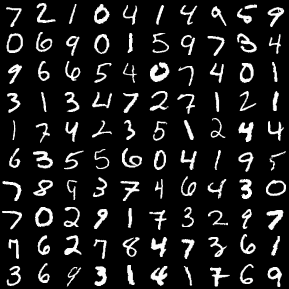

In [22]:
original_img = Image.fromarray(tile_raster_images(X=test_data,
                                                  img_shape=(28,28),
                                                  tile_shape=(10,10),
                                                  tile_spacing=(1,1)))
original_img.save('delete_me.png')
print 'original'
I.display(I.Image('delete_me.png'))

Z1e 3.pkl


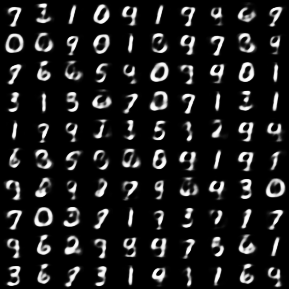

Z1e finetune.pkl


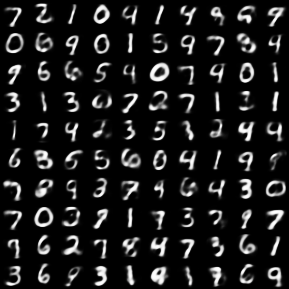

Z1c_90 3.pkl


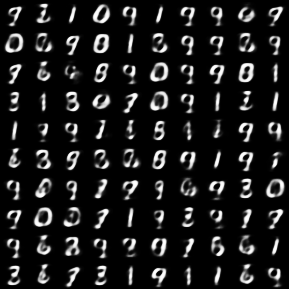

Z1c_90 finetune.pkl


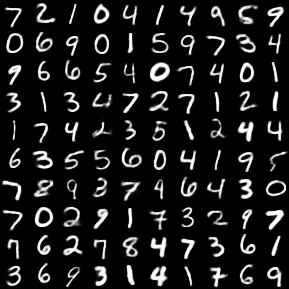

Z1b 3.pkl


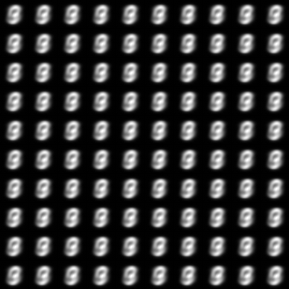

Z1b finetune.pkl


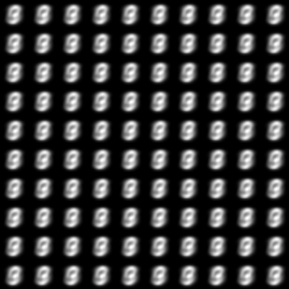

In [25]:
for model_folder in model_folders:
    for submodel in ['3.pkl','finetune.pkl']:
        reconstructed = Image.fromarray(tile_raster_images(X=xhat[model_folder][submodel],
                                                  img_shape=(28,28),
                                                  tile_shape=(10,10),
                                                  tile_spacing=(1,1)))
        reconstructed.save('delete_me.png')
        print model_folder, submodel
        I.display(I.Image('delete_me.png'))

In [27]:
model_folders = ['Z1e']
import cPickle as pickle
params = [pickle.load(open(os.path.join(dir_model,model_folder,'params.pkl'),'r')) for model_folder in model_folders]

In [28]:
params

[{'corruptions': [0.1, 0.2, 0.3, 0.3],
  'dec_activations': ['"sigmoid"', '"sigmoid"', '"sigmoid"', '"sigmoid"'],
  'dir_fuel': '/home/ubuntu/data/AE_experiments/fuel',
  'dir_models': '/home/ubuntu/data/AE_experiments/models/Z1e',
  'enc_activations': ['"sigmoid"', '"sigmoid"', '"sigmoid"', '"sigmoid"'],
  'finetune_batch_size': 100,
  'finetune_cost_YAML': '!obj:train_AE.XtropyReconstructionCost',
  'finetune_epochs': 300,
  'finetune_lr': 0.1,
  'monitoring_batches': 5,
  'n_units': [784, 1000, 1000, 1000, 15],
  'path_YAML_finetune': 'finetune_simpletrain.yaml',
  'paths_YAML_pretrains': ['layer0_skeleton.yaml',
   'layer1_skeleton.yaml',
   'layer2_skeleton.yaml',
   'layer3_skeleton.yaml'],
  'pretrain_batch_size': 10,
  'pretrain_cost_YAML': '!obj:train_AE.XtropyReconstructionCost',
  'pretrain_epochs': 15,
  'pretrain_lr': 0.784,
  'train_stop': 50000,
  'valid_stop': 60000}]